# Timeseries forecasting CNN, RNN, DNN

### About Sunspots

Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.

#### Data Download

In [142]:
import os
import zipfile
import pandas as pd
import shutil

# Step 1: Define the dataset download path
dataset_directory = "/Users/amit/Documents/Data Science/Kaggle/sunspots_data"

# Step 2: Create the directory if it doesn't exist
os.makedirs(dataset_directory, exist_ok=True)

# Step 3: Download the dataset
# Make sure you have the Kaggle API key configured correctly
!kaggle datasets download -d robervalt/sunspots -p "{dataset_directory}"

# Step 4: Unzip the dataset
zip_file_path = os.path.join(dataset_directory, 'sunspots.zip')
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_directory)
    print("Dataset unzipped successfully.")
else:
    print(f"Error: {zip_file_path} not found.")

# Step 5: Load the data (assuming it's named 'Sunspots.csv' after extraction)
data_file_path = os.path.join(dataset_directory, 'Sunspots.csv')  # Adjust if the CSV file has a different name
if os.path.exists(data_file_path):
    data = pd.read_csv(data_file_path)
    print("Data loaded successfully:")
    print(data.head())  # Display the first few rows of the dataset
else:
    print(f"Error: {data_file_path} not found.")

Dataset URL: https://www.kaggle.com/datasets/robervalt/sunspots
License(s): CC0-1.0
sunspots.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset unzipped successfully.
Data loaded successfully:
   Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0           0  1749-01-31                               96.7
1           1  1749-02-28                              104.3
2           2  1749-03-31                              116.7
3           3  1749-04-30                               92.8
4           4  1749-05-31                              141.7


# Import

In [144]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

# Utilities

In [146]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data
    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """
    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Preview the data

In [148]:
# Assuming 'data' is your DataFrame and it contains 'Date' and 'Sunspots' columns
# Adjust the column names based on your actual DataFrame

# Initialize lists
time_step = []
sunspots = []

# Populate the lists
for index, row in data.iterrows():
    time_step.append(row['Unnamed: 0'])  # Replace 'Date' with the actual name of the timestamp column
    sunspots.append(row['Monthly Mean Total Sunspot Number'])  # Replace 'Sunspots' with the actual name of the sunspots column

# Optional: Print the first few entries to verify
print("Time Steps:", time_step[:5])
print("Sunspots:", sunspots[:5])

Time Steps: [0, 1, 2, 3, 4]
Sunspots: [96.7, 104.3, 116.7, 92.8, 141.7]


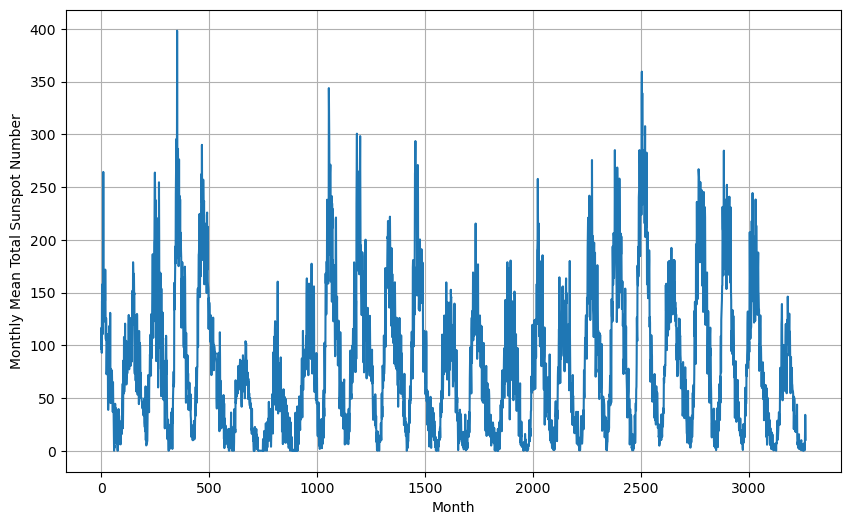

In [149]:
# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

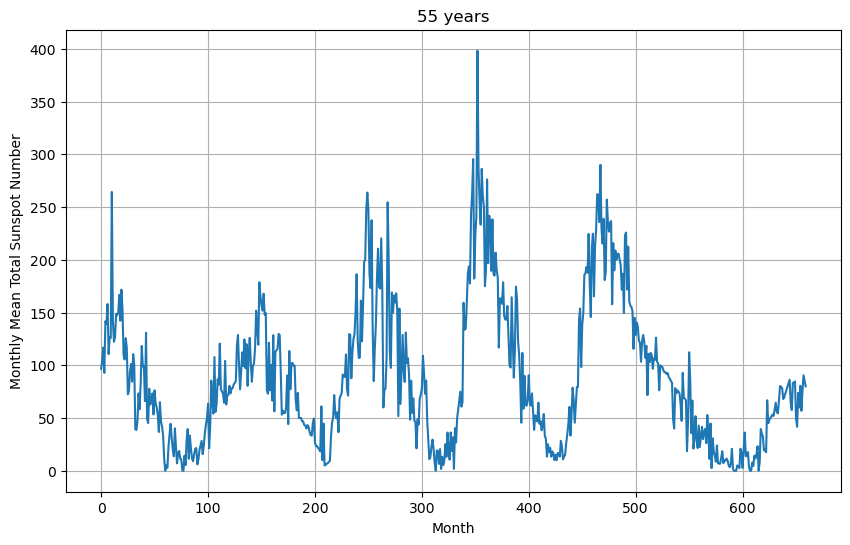

In [150]:
# Only plot the first 660 of timestamp
zoom_split = 660

# Plot zoomed mae and loss
plot_series(
    x=time[:zoom_split], 
    y=(series[:zoom_split]), 
    title='55 years', 
    xlabel='Month',
    ylabel='Monthly Mean Total Sunspot Number'
    )

# Split the dataset

In [152]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Prepare features & labels

In [154]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

## tweak the below parameters if needed

In [156]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Building the model

In [158]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

/Users/amit/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

# Tune the learning rate

In [160]:
# Get initial weights
init_weights = model.get_weights()

In [161]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose = 2)

Epoch 1/100
93/93 - 2s - 21ms/step - loss: 228.3577 - learning_rate: 1.0000e-08
Epoch 2/100


/Users/amit/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 - 1s - 12ms/step - loss: 143.3007 - learning_rate: 1.1220e-08
Epoch 3/100
93/93 - 1s - 12ms/step - loss: 79.9862 - learning_rate: 1.2589e-08
Epoch 4/100
93/93 - 1s - 12ms/step - loss: 51.5933 - learning_rate: 1.4125e-08
Epoch 5/100
93/93 - 1s - 12ms/step - loss: 44.1945 - learning_rate: 1.5849e-08
Epoch 6/100
93/93 - 1s - 11ms/step - loss: 41.9741 - learning_rate: 1.7783e-08
Epoch 7/100
93/93 - 1s - 11ms/step - loss: 40.6602 - learning_rate: 1.9953e-08
Epoch 8/100
93/93 - 1s - 11ms/step - loss: 39.5608 - learning_rate: 2.2387e-08
Epoch 9/100
93/93 - 1s - 12ms/step - loss: 38.5826 - learning_rate: 2.5119e-08
Epoch 10/100
93/93 - 1s - 12ms/step - loss: 37.6720 - learning_rate: 2.8184e-08
Epoch 11/100
93/93 - 1s - 11ms/step - loss: 36.7595 - learning_rate: 3.1623e-08
Epoch 12/100
93/93 - 1s - 12ms/step - loss: 35.2943 - learning_rate: 3.5481e-08
Epoch 13/100
93/93 - 1s - 11ms/step - loss: 33.7585 - learning_rate: 3.9811e-08
Epoch 14/100


2024-10-26 20:54:41.656220: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 - 1s - 11ms/step - loss: 32.7411 - learning_rate: 4.4668e-08
Epoch 15/100
93/93 - 1s - 11ms/step - loss: 31.8053 - learning_rate: 5.0119e-08
Epoch 16/100
93/93 - 1s - 11ms/step - loss: 31.0917 - learning_rate: 5.6234e-08
Epoch 17/100
93/93 - 1s - 14ms/step - loss: 30.4196 - learning_rate: 6.3096e-08
Epoch 18/100
93/93 - 1s - 11ms/step - loss: 29.4953 - learning_rate: 7.0795e-08
Epoch 19/100
93/93 - 1s - 12ms/step - loss: 28.2494 - learning_rate: 7.9433e-08
Epoch 20/100
93/93 - 1s - 12ms/step - loss: 27.0344 - learning_rate: 8.9125e-08
Epoch 21/100
93/93 - 1s - 12ms/step - loss: 26.2061 - learning_rate: 1.0000e-07
Epoch 22/100
93/93 - 1s - 11ms/step - loss: 25.0282 - learning_rate: 1.1220e-07
Epoch 23/100
93/93 - 1s - 12ms/step - loss: 23.9620 - learning_rate: 1.2589e-07
Epoch 24/100
93/93 - 1s - 11ms/step - loss: 23.9266 - learning_rate: 1.4125e-07
Epoch 25/100
93/93 - 1s - 11ms/step - loss: 22.7437 - learning_rate: 1.5849e-07
Epoch 26/100
93/93 - 1s - 12ms/step - loss: 22.5908 -

(1e-08, 0.001, 0.0, 100.0)

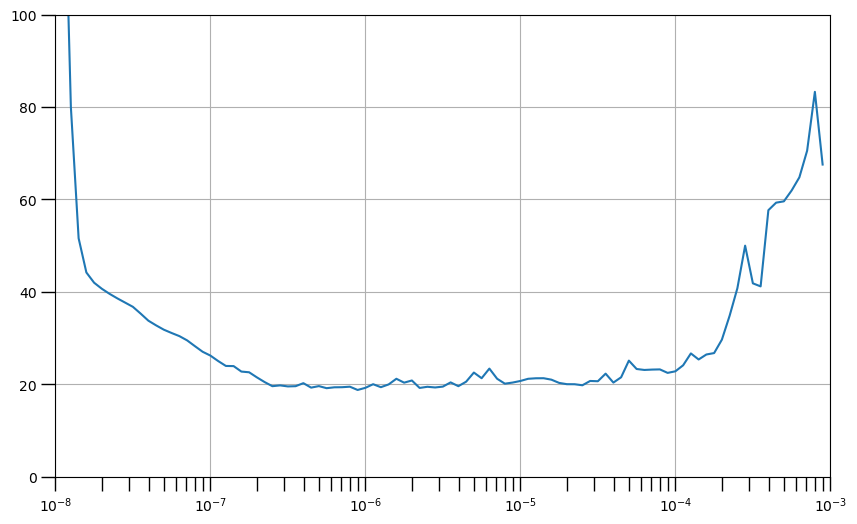

In [162]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

# Train the model

In [164]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [165]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [166]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 94.0600 - mae: 94.5582
Epoch 2/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 29.2398 - mae: 29.7359

/Users/amit/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 26.7778 - mae: 27.2737
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.9983 - mae: 23.4924
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.1596 - mae: 22.6540
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.7505 - mae: 21.2427
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.8219 - mae: 22.3164
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.4844 - mae: 20.9794
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.6144 - mae: 20.1068
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.3943 - mae: 19.8852
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.3756 - mae: 19.8687
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.7132 - mae: 19.2047
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.6459 - mae: 19.1371
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.7066 - mae: 20.1976
Epoch 14/100

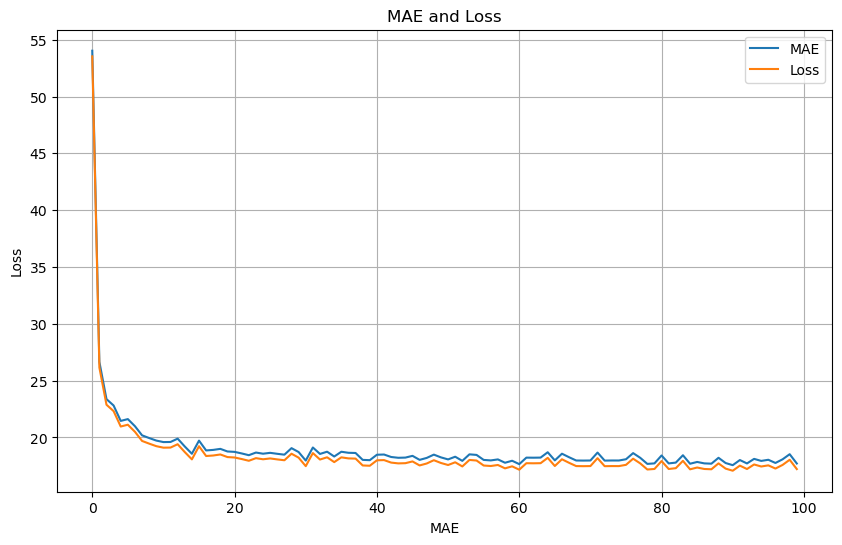

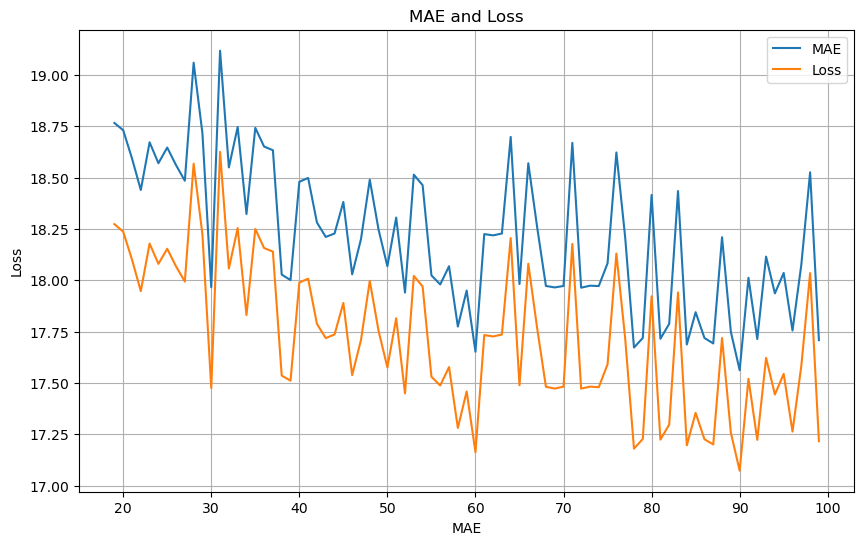

In [167]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Model prediction

In [169]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/Users/amit/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


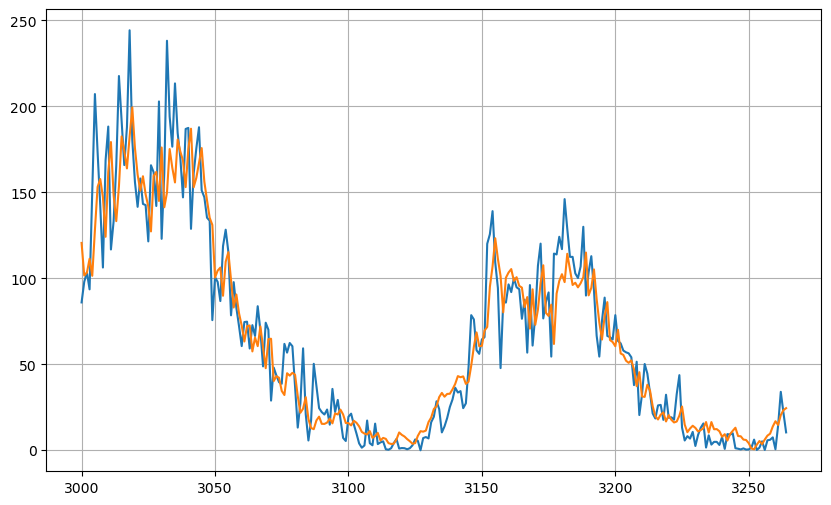

In [170]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [171]:
# Instantiate the Mean Absolute Error metric
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# Update the state of the metric with your actual and predicted values
mae_metric.update_state(x_valid, results)

# Compute the final MAE value
mae_value = mae_metric.result().numpy()

print("Mean Absolute Error:", mae_value)

Mean Absolute Error: 13.932077


# Setting the learning rate decay

In [ ]:
%%time
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100, verbose = 0)

/Users/amit/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 50% of the epochs
zoom_split = int(epochs[-1] * 0.5)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
# Instantiate the Mean Absolute Error metric
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# Update the state of the metric with your actual and predicted values
mae_metric.update_state(x_valid, results)

# Compute the final MAE value
mae_value = mae_metric.result().numpy()

print("Mean Absolute Error:", mae_value)